In [1]:
%config Completer.use_jedi = False

In [46]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
#import geoplot as gplt
#import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.VRPtest import *
from Problem.utils import *
#import geoplot as gplt
#import geopandas as gpd
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

# 25_2, 25_4, 25_8, 50_1, 50_2, 50_4, 75_1, 75_3, 75_6
dataset = "UK75_1"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

station_coordinates = pd.read_csv('../datasets/{}/{}_coordinates.csv'.format(dataset[:-2],dataset), encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()
#dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
#dbf = dbf.to_crs("EPSG:4326")
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/{}/".format(dataset[:-2]),dataset)

distance_matrix_here = distance_matrix_here.to_numpy()
time_matrix_here = time_matrix_here.to_numpy()

routingContext = RoutingContext(distance_matrix=distance_matrix_here,time_matrix=time_matrix_here,station_coordinates=station_coordinates,station_data=station_data,meta_data=meta_data)
startNodes = {"UK20_1":[0,6,10,15],"UK25":[0,6,10,15],"UK50":[0,6,10,15,21,35,40],"UK75":[0,6,10,15,21,35,40,60,31,68]}
endNodes = {"UK20_1":[4,20,2,5],"UK25":[4,20,2,5,22],"UK50":[4,20,2,5,32,45,1],"UK75":[4,20,2,5,32,45,1]}


evaluation_amount = {"UK25":3000,"UK50":5000,"UK75":10000}

In [47]:
startNodeIndeces = startNodes[dataset[:-2]]
endNodeIndeces = endNodes[dataset[:-2]]
locationNodeIndeces = list((set(range(len(points_coordinate))) - set(startNodeIndeces)) - set(endNodeIndeces))

vehicleData = {"emptyWeights":[3000,5500],"maxLoads":[3650,8500],"fuelEmpty":[12,22.5],"fuelFull":[15,27.5]}


vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,heterogeneousFleet=True)

customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[startNodeIndeces+endNodeIndeces] = 0
station_data["Demand(kg)"] = customer_demands

translate_dict = {}
for i,x in enumerate(endNodeIndeces):
    translate_dict[x] = 100+i
initial_solution = cheapest_insertion_dict(locationNodeIndeces,vehicles,endNodeIndeces,routingContext)



cost_function_dict = {"distance_matrix":distance_matrix_here,"time_matrix":time_matrix_here,
                              "demands":customer_demands,"vehicle_weight":3000,"start_positions":startNodeIndeces,"meta_data":meta_data}


min_allowed_drivetime_hours = 0


data_model_input_multi_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':2,'objective_labels':['Total Fuel','Total Drive Time'],
                                    'constraint_amount':6,'number_of_cities':routingContext.distance_matrix.shape[0],
                                    'min_drivetime':min_allowed_drivetime_hours}

data_model_input_single_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':1,'objective_labels':['Total Fuel'],
                                    'constraint_amount':6,'number_of_cities':routingContext.distance_matrix.shape[0],
                                    'min_drivetime':min_allowed_drivetime_hours}

problem = VRP(data_model_input_multi_objective)

plot_data_storage_base = {'fitness':[], 'route_distance':[],'fuel_consumption':[],'vehicle_loads':[],'computation_times':[],'vehicle_route_time':[],'violation':[],'paths':[],'distance_to_origin':[]}


amount_of_runs = 30
amount_of_evaluations = evaluation_amount[dataset[:-2]]
observer_update_interval = 60
logpath = "parameter_data/reruns_L1/{}".format(dataset)
try: 
    os.mkdir(logpath) 
except OSError as error: 
    print(error) 
mutation_arange = np.arange(0.1,1,0.2)
crossover_arange = np.arange(0.25,0.8,0.25)
population_size_arange = np.arange(10,40,10)


genetic_algorithms_parameters = []

for x in mutation_arange:
    for y in crossover_arange:
        for z in population_size_arange:
            genetic_algorithms_parameters.append({"mutation":np.round(x,2),"crossover":np.round(y,2),"population_size":np.round(z,2)})

            
optimal_parameters = {"SA":{"mutation":0.9}, "GA":{"mutation":0.9,"crossover":0.25,"population_size":30},
                     "NSGAII":{"mutation":0.9,"crossover":0.50,"population_size":30},
                     "NSGAIII":{"mutation":0.9,"crossover":0.50,"population_size":20},
                     "UNSGAIII":{"mutation":0.9,"crossover":0.25,"population_size":20},
                     "IBEA":{"mutation":0.9,"crossover":0.75,"population_size":20}}
            


[Errno 17] File exists: 'parameter_data/reruns_L1/UK75_1'


In [48]:
def plot_vehicle_drivetimes(dataframe,parameter_group):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig, ax = plt.subplots(1,1)
    
    dataframe_parameter_group = dataframe.where(dataframe["Parameter Group"] == parameter_group).dropna()
    
    if type(dataframe_parameter_group.vehicle_route_time.iloc[0]) == str:
        dataframe_parameter_group.vehicle_route_time = dataframe_parameter_group.vehicle_route_time.apply(literal_eval)
        
    dataframe_parameter_group["vehicle_amount"] = dataframe_parameter_group.vehicle_route_time.apply(lambda x: len(x))
    
    vehicle_amounts = sorted(dataframe_parameter_group.vehicle_amount.unique())
    num_bars = len(vehicle_amounts)
    offsets = np.linspace(-num_bars/12, num_bars/12, num_bars)
    
    for vehicle_amount,offset in zip(vehicle_amounts,offsets):
        vehicle_amount_df = dataframe_parameter_group.where(dataframe_parameter_group.vehicle_amount == vehicle_amount).dropna()
        
        vehicle_amount_route_times = np.stack(vehicle_amount_df.vehicle_route_time.apply(lambda x: np.sort(x)[::-1]/60).to_numpy())
        vehicle_route_times_mean = np.mean(vehicle_amount_route_times,axis=0)
        plt.bar(np.arange(vehicle_amount) + offset,vehicle_route_times_mean,width=0.2,alpha=0.5,label=r"$\bf{%s}\ Vehicles$" % (vehicle_amount))
    
    plt.ylabel("Drivetime (minutes)")
    plt.xlabel("Vehicles")
    
    plt.legend(bbox_to_anchor=(1,1))
        
    
    

# Simulated Annealing

In [5]:
from jmetal.algorithm.singleobjective import SimulatedAnnealing
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation,SimpleRandomMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.comparator import DominanceComparator
from datetime import datetime

parameters_SA = optimal_parameters["SA"]

plot_data_SA = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):
    problem_SA = VRP(data_model_input_single_objective)
    problem_SA.name = "SA"
    problem_SA.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_SA = SimulatedAnnealing(problem=problem_SA,
                                   mutation=PermutationSwapMutation(parameters_SA["mutation"]),
                                   termination_criterion=StoppingByEvaluations(max_evaluations))

    performance_observer_SA = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_SA])
    performance_observer_SA.maxEpochs=  amount_of_runs
    performance_observer_SA.currentEpoch = x

    algorithm_SA.observable.register(observer=performance_observer_SA)
    algorithm_SA.run() 

    solutions_SA = algorithm_SA.get_result()        
    store_plot_data(plot_data_SA,performance_observer_SA,solutions_SA)


sa_numerical_path = get_numerical_path(solutions_SA.path,vehicles)


Epoch:1 of 30
Evaluations: 1560/10000
Params: {'mutation': 0.9}
IGD:2802.6523973536764
Best fitness: 1296.4828                          
Best total fuel consumption:363.82 
Best total drive time:2622.8                          
Computing time: 2.05s
Average computing speed: 762.19it/s                          
Current Route:[['V0', 64, 14, 8, 28, 45], ['V1', 55, 53, 45], ['V5', 56, 58, 30, 48, 11, 2], ['V4', 61, 3, 71, 74, 16, 9, 62, 52, 4], ['V6', 72, 59, 29, 39, 19, 45], ['V8', 69, 37, 25, 46, 5], ['V9', 23, 75, 34, 50, 5], ['V14', 43, 5], ['V11', 38, 51, 47, 7, 44, 24, 20], ['V16', 13, 54, 5], ['V12', 22, 18, 42, 65, 17, 36, 41, 49, 5], ['V18', 33, 57, 70, 26, 63, 67, 73, 66, 2], ['V19', 12, 27, 45]]
Flags: ['overload']
Violation:-624.0
Vehicle Amount:13


KeyboardInterrupt: 

# Genetic Algorithm

In [94]:
from jmetal.algorithm.singleobjective import GeneticAlgorithm
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator.selection import Selection
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.observer import ProgressBarObserver, VisualizerObserver,PrintObjectivesObserver,BasicObserver
from jmetal.util.evaluator import MultiprocessEvaluator
from datetime import datetime


parameters_GA = optimal_parameters["GA"]



plot_data_GA = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):
    problem_GA = VRP(data_model_input_single_objective)
    problem_GA.name = "GA"
    problem_GA.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_GA = GeneticAlgorithm(problem=problem_GA,
                    population_size=parameters_GA["population_size"],
                    offspring_population_size=parameters_GA["population_size"],
                    mutation=PermutationSwapMutation(parameters_GA["mutation"]),
                    crossover=PMXCrossover(parameters_GA["crossover"]),
                    selection=BestSolutionSelection(),
                    termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
                    ,population_evaluator=MultiprocessEvaluator()
                    )


    performance_observer_GA = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_GA])
    performance_observer_GA.maxEpochs= amount_of_runs
    performance_observer_GA.currentEpoch = x
    algorithm_GA.observable.register(observer=performance_observer_GA)
    
    start_time = datetime.now() 
    algorithm_GA.run()
    run_time = datetime.now() - start_time
    solutions_GA = algorithm_GA.get_result()


    store_plot_data(plot_data_GA,performance_observer_GA,solutions_GA)
    

Epoch:30 of 30
Evaluations: 10020/10000
Params: {'mutation': 0.9, 'crossover': 0.25, 'population_size': 30}
IGD:2611.970731732772
Best fitness: 1252.4925                          
Best total fuel consumption:338.16 
Best total drive time:2428.3                          
Computing time: 11.56s
Average computing speed: 866.85it/s                          
Current Route:[['V14', 28, 8, 14, 64, 32], ['V1', 55, 53, 45], ['V5', 58, 11, 48, 30, 56, 61, 3, 20], ['V4', 71, 74, 16, 9, 62, 52, 4], ['V6', 72, 29, 39, 59, 19, 45], ['V8', 69, 32], ['V9', 37, 25, 23, 50, 34, 13, 54, 46, 75, 4], ['V11', 38, 51, 47, 7, 44, 24, 20], ['V12', 22, 45], ['V0', 43, 5], ['V16', 18, 42, 65, 17, 36, 41, 49, 5], ['V18', 33, 57, 70, 26, 63, 67, 73, 66, 2], ['V19', 12, 27, 45]]
Flags: ['overload']
Violation:-624.0
Vehicle Amount:13


# NSGA-II

In [10]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAII, UniformReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameters_NSGAII = optimal_parameters["NSGAII"]

plot_data_NSGAII = deepcopy(plot_data_storage_base)
for x in range(1):
    problem_NSGAII = VRP(data_model_input_multi_objective)
    problem_NSGAII.name = "NSGA-II"
    problem_NSGAII.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_NSGAII = NSGAII(problem=problem_NSGAII,
                            population_size=parameters_NSGAII["population_size"],
                            offspring_population_size=parameters_NSGAII["population_size"],
                            mutation=PermutationSwapMutation(parameters_NSGAII["mutation"]),
                            crossover=PMXCrossover(parameters_NSGAII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations),
                            population_evaluator=MultiprocessEvaluator()

                               )

    performance_observer_NSGAII = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_NSGAII])
    performance_observer_NSGAII.maxEpochs= amount_of_runs
    performance_observer_NSGAII.currentEpoch = x



    algorithm_NSGAII.observable.register(observer=performance_observer_NSGAII)
    algorithm_NSGAII.run()

    solutions_NSGAII = algorithm_NSGAII.get_result()
    front_NSGAII = get_non_dominated_solutions(solutions_NSGAII)
    best_sol = sorted(front_NSGAII,key=lambda solution:np.sum(solution.objectives))[0]
    
    store_plot_data(plot_data_NSGAII,performance_observer_NSGAII,best_sol)

Epoch:1 of 30
Evaluations: 10020/10000
Params: {'mutation': 0.9, 'crossover': 0.5, 'population_size': 30} 
IGD:636.9503931922079
Best fitness: 454.8068 --- 445.9333                        
Best total fuel consumption:454.81 
Computing time: 10.92s                        
Average computing speed: 917.69it/s
Current Route:[['V2', 47, 50, 22, 19, 5], ['V7', 72, 2], ['V8', 18, 33, 23, 74, 48, 57, 56, 4], ['V3', 3, 13, 54, 34, 11, 45], ['V4', 44, 69, 24, 55, 42, 59, 26, 1], ['V5', 67, 38, 52, 30, 70, 37, 14, 12, 41, 45], ['V9', 9, 16, 7, 39, 43, 25, 51, 61, 5], ['V1', 71, 17, 75, 66, 27, 62, 5], ['V0', 53, 63, 65, 1], ['V6', 28, 58, 36, 2], ['V10', 64, 46, 49, 73, 29, 20], ['V14', 8, 32]]
Flags: []                        
Violation:0
Vehicle amount:12


In [11]:
front_NSGAII

# NSGA-III

In [14]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator
from Problem.VRPGini import *



parameters_NSGAIII = optimal_parameters["NSGAIII"]


plot_data_NSGAIII = deepcopy(plot_data_storage_base)

for x in range(1):
    
    problem_NSGAIII = VRP(data_model_input_multi_objective)
    problem_NSGAIII.name = "NSGA-III"
    problem_NSGAIII.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                            population_size=parameters_NSGAIII["population_size"],
                            reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                            mutation= PermutationSwapMutation(parameters_NSGAIII["mutation"]),
                            crossover=PMXCrossover(parameters_NSGAIII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations)
                            ,population_evaluator=MultiprocessEvaluator()
                               )
    performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_NSGAIII])
    performance_observer_NSGAIII.maxEpochs=  amount_of_runs
    performance_observer_NSGAIII.currentEpoch =  x

    algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
    algorithm_NSGAIII.run()

    solutions_NSGAIII = algorithm_NSGAIII.get_result()
    front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)
    
    best_sol = sorted(front_NSGAIII,key=lambda solution:np.sum(solution.objectives))[0]
    store_plot_data(plot_data_NSGAIII,performance_observer_NSGAIII,best_sol)

Epoch:1 of 30
Evaluations: 9960/10000
Params: {'mutation': 0.9, 'crossover': 0.5, 'population_size': 20}
Best fitness: 535.5497 --- 462.8667 --- 138.3762                        
Best total fuel consumption:535.55 
Computing time: 11.59s                        
Average computing speed: 859.57it/s
Current Route:[['V2', 23, 63, 42, 59, 1], ['V7', 43, 50, 74, 33, 48, 57, 47, 2], ['V3', 51, 3, 69, 54, 13, 34, 11, 41, 45], ['V5', 24, 26, 65, 53, 22, 19, 61, 62, 5], ['V4', 38, 52, 67, 30, 37, 14, 12, 45], ['V6', 18, 16, 7, 39, 36, 17, 9, 72, 2], ['V10', 44, 75, 27, 66, 25, 2], ['V1', 56, 55, 70, 45], ['V8', 58, 28, 2], ['V0', 71, 64, 46, 49, 73, 29, 20], ['V14', 8, 32]]
Flags: []                        
Violation:0
Vehicle amount:11


In [15]:
for sol in sorted(front_NSGAIII,key=lambda solution:np.sum(solution.objectives)):
    print(sol.objectives)
    

[535.5496946915988, 462.8666666666667, 138.37624363940154]
[554.9016277563854, 455.81666666666666, 127.0248617848134]
[535.0896384558051, 462.8666666666667, 141.85718827057076]
[542.2023869778891, 455.81666666666666, 143.1140096912809]
[564.7451695236854, 455.81666666666666, 121.0522713234628]
[546.0210961495178, 455.81666666666666, 139.82125525719832]
[571.7127190972835, 455.81666666666666, 119.08919429383964]
[574.4264120575307, 455.81666666666666, 118.62891207153501]
[530.7879270170858, 462.8666666666667, 172.75743139341805]
[532.2147884655956, 462.8666666666667, 172.24562181334517]
[710.0895413190282, 462.8666666666667, 104.25049420836514]
[715.9926205909193, 462.8666666666667, 98.98568636234786]


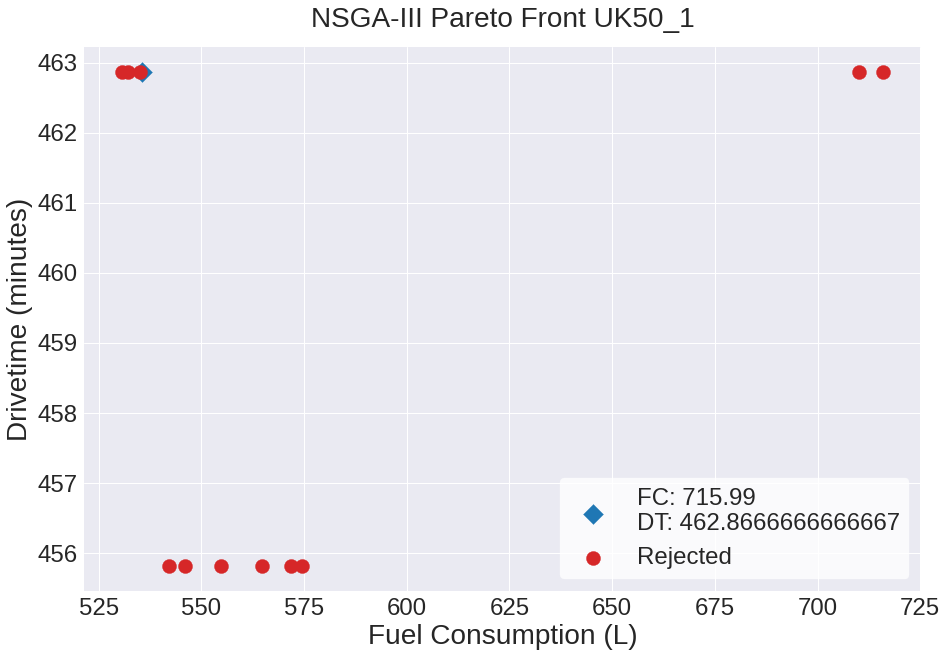

In [18]:

plt.figure(figsize=(15,10))
plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")

rejected_solutions = np.array([sol.objectives for sol in list(filter(lambda x: x != best_sol,front_NSGAIII))])


plt.scatter(x=best_sol.objectives[0],y = best_sol.objectives[1],marker="D",color="tab:blue",s=200,label="FC: {}\nDT: {}".format(np.round(sol.objectives[0],2),sol.objectives[1]))
plt.scatter(x=rejected_solutions[:,0],y = rejected_solutions[:,1],color="tab:red",s=200,label="Rejected")

        

plt.title("NSGA-III Pareto Front UK50_1")
plt.ylabel("Drivetime (minutes)")
plt.xlabel("Fuel Consumption (L)")
legend =plt.legend(frameon=True,fancybox=True)
frame =legend.get_frame()
frame.set_color('white')
plt.savefig("pareto_front_solution_selection_example.pdf")
plt.show()

In [23]:
front_NSGAIII

# UNSGA-III

In [ ]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameters_UNSGAIII = optimal_parameters["UNSGAIII"]

plot_data_UNSGAIII = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):

    problem_UNSGAIII = VRP(data_model_input_multi_objective)
    problem_UNSGAIII.name = "NSGA-III"
    problem_UNSGAIII.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_UNSGAIII = UNSGAIII(problem=problem_UNSGAIII,
                            population_size=parameters_UNSGAIII["population_size"],
                            reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                            mutation= PermutationSwapMutation(parameters_UNSGAIII["mutation"]),
                            crossover=PMXCrossover(parameters_UNSGAIII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations)
                            ,population_evaluator=MultiprocessEvaluator()
                               )
    performance_observer_UNSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_UNSGAIII])
    performance_observer_UNSGAIII.maxEpochs= amount_of_runs
    performance_observer_UNSGAIII.currentEpoch =  x

    algorithm_UNSGAIII.observable.register(observer=performance_observer_UNSGAIII)
    algorithm_UNSGAIII.run()

    solutions_UNSGAIII = algorithm_UNSGAIII.get_result()
    front_UNSGAIII = get_non_dominated_solutions(solutions_UNSGAIII)
    best_sol = sorted(front_UNSGAIII,key=lambda solution:np.sum(solution.objectives))[0]
    store_plot_data(plot_data_UNSGAIII,performance_observer_UNSGAIII,best_sol)

Epoch:4 of 30
Evaluations: 1920/5000
Params: {'mutation': 0.9, 'crossover': 0.25, 'population_size': 20} 
IGD:217.2839171971769
Best fitness: 217.2838 --- 0.1845                        
Best total fuel consumption:217.28 
Computing time: 1.91s                        
Average computing speed: 1002.69it/s
Current Route:[['V0', 42, 30, 33, 19, 34, 29, 2], ['V2', 31, 37, 44, 2], ['V3', 48, 4], ['V4', 11, 18, 39, 20], ['V6', 47, 46, 8, 27, 24, 50, 26, 7, 45], ['V9', 36, 17, 25, 13, 14, 16, 38, 2], ['V10', 41, 45], ['V12', 49, 3, 12, 23, 9, 28, 20], ['V13', 22, 43, 20]]
Flags: []                        
Violation:0
Vehicle amount:9


Process ForkPoolWorker-71:
Process ForkPoolWorker-69:
Process ForkPoolWorker-72:
Process ForkPoolWorker-67:
Process ForkPoolWorker-62:
Process ForkPoolWorker-70:
Process ForkPoolWorker-65:
Process ForkPoolWorker-68:
Process ForkPoolWorker-66:
Traceback (most recent call last):
Process ForkPoolWorker-64:
Process ForkPoolWorker-61:
Process ForkPoolWorker-63:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):


In [23]:
get_solution_results(front_UNSGAIII[0],routingContext,vehicles)

,Total distance (km),Total Travel Time (h),Total load (kg),Fuel Consumption (L),Avg Fuel Conspumtion (L/100km),Avg Speed (km/h)
0,163.222,03:15:30,2280.0,27.650934,16.940691,50.093708
1,184.223,03:45:05,2033.0,28.538118,15.491072,49.107945
2,149.042,02:38:31,1585.0,22.319021,14.974987,56.413752
3,125.618,02:46:45,2091.0,20.564363,16.370554,45.199880
4,142.617,02:57:35,3431.0,22.901764,16.058228,48.185941
5,97.270,02:31:34,2831.0,17.166401,17.648196,38.505828
6,135.209,03:19:37,2934.0,21.765741,16.097849,40.640594
7,16.633,34:45,1456.0,2.815233,16.925590,28.718849
8,119.834,03:38:00,4814.0,22.926601,19.131966,32.981835


# IBEA

In [49]:
from jmetal.algorithm.multiobjective.ibea import IBEA
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameters_IBEA = optimal_parameters["IBEA"]

plot_data_IBEA = deepcopy(plot_data_storage_base)
for x in range(1):
    problem_IBEA = VRP(data_model_input_multi_objective)
    problem_IBEA.name = "IBEA"
    problem_IBEA.assignClosestEndPoint = True
    max_evaluations = 10000

    algorithm_IBEA = IBEA(problem=problem_IBEA,
                            population_size=parameters_IBEA["population_size"],
                            offspring_population_size=parameters_IBEA["population_size"],
                            kappa =1,
                            mutation=PermutationSwapMutation(parameters_IBEA["mutation"]),
                            crossover=PMXCrossover(parameters_IBEA["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations),
                            population_evaluator=MultiprocessEvaluator(),
                               )

    performance_observer_IBEA = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_IBEA])
    performance_observer_IBEA.maxEpochs= amount_of_runs
    performance_observer_IBEA.currentEpoch =  x


    algorithm_IBEA.observable.register(observer=performance_observer_IBEA)
    algorithm_IBEA.run()

    solutions_IBEA = algorithm_IBEA.get_result()
    front_IBEA = get_non_dominated_solutions(solutions_IBEA)
    
    best_sol = sorted(front_IBEA,key=lambda solution:np.sum(solution.objectives))[0]
    store_plot_data(plot_data_IBEA,performance_observer_IBEA,best_sol)


Epoch:30 of 30
Evaluations: 9960/10000
Params: {'mutation': 0.9, 'crossover': 0.75, 'population_size': 20}
Best fitness: 581.5816 --- 433.4667 --- 131.6008                        
Best total fuel consumption:581.58 
Computing time: 15.94s                        
Average computing speed: 624.87it/s
Current Route:[['V7', 19, 63, 56, 22, 27, 66, 16, 9, 2], ['V3', 50, 23, 48, 33, 57, 74, 61, 5], ['V1', 65, 13, 54, 34, 11, 51, 5], ['V4', 12, 64, 24, 26, 1], ['V5', 52, 42, 59, 55, 67, 53, 4], ['V0', 70, 44, 14, 37, 30, 38, 4], ['V2', 47, 7, 43, 25, 75, 32], ['V9', 39, 17, 72, 18, 41, 45], ['V6', 36, 62, 69, 45], ['V8', 28, 58, 2], ['V10', 3, 71, 46, 29, 73, 49, 45], ['V14', 8, 32]]
Flags: []                        
Violation:0
Vehicle amount:12


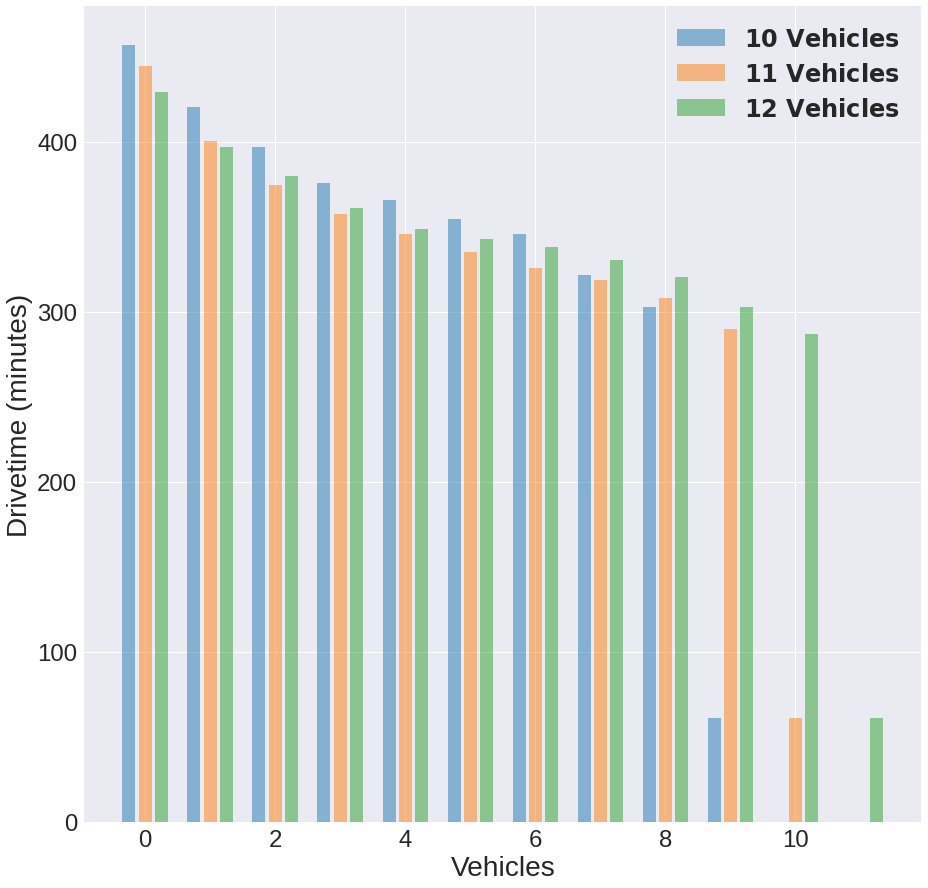

In [50]:
plot_data_IBEA["Parameter Group"]=1
plot_vehicle_drivetimes(pd.DataFrame(plot_data_IBEA),parameter_group=1)

In [51]:
pd.DataFrame(plot_data_IBEA).to_csv("{}/IBEA_gini_third_objective.csv".format(logpath))

<BarContainer object of 10 artists>

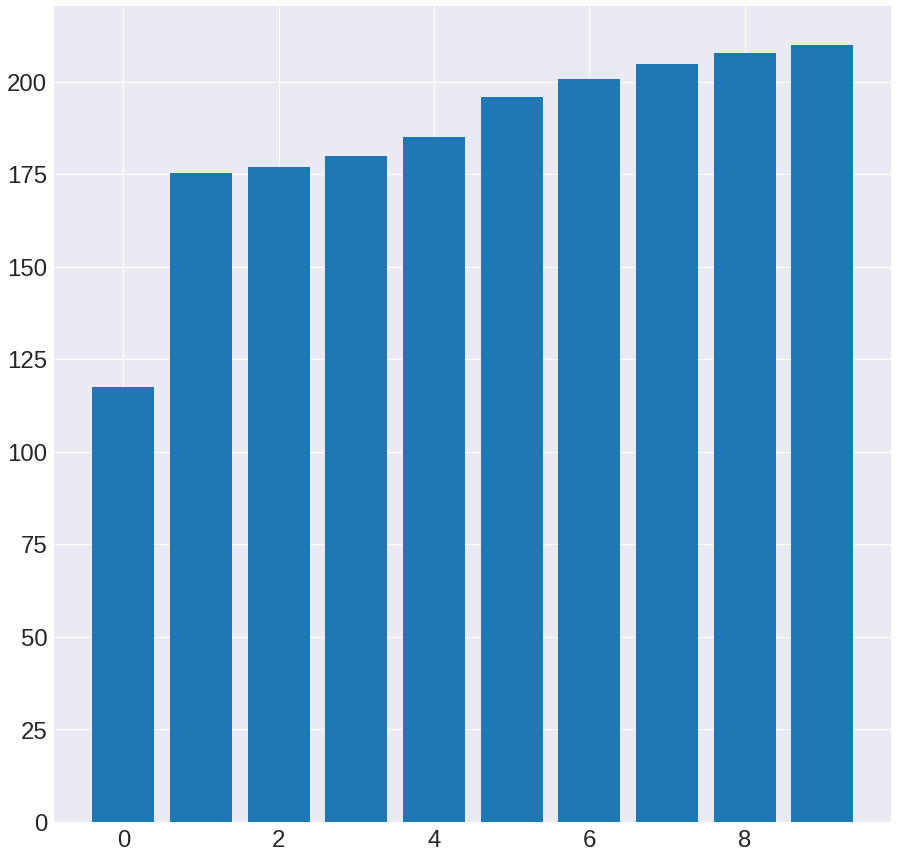

In [35]:
plt.bar(range(0,len(np.array(best_sol.vehicle_route_times)/60)),height=sorted(np.array(best_sol.vehicle_route_times)/60))

In [6]:
sorted(np.array(best_sol.vehicle_route_times)/60)

[115.21666666666667,
 165.76666666666668,
 171.4,
 174.73333333333332,
 177.65,
 185.33333333333334,
 185.55,
 190.33333333333334,
 193.78333333333333,
 196.26666666666668,
 260.81666666666666,
 320.71666666666664,
 322.9166666666667]

In [25]:
#pd.DataFrame(plot_data_IBEA).to_csv("{}/IBEA.csv".format(logpath))

In [27]:
sa_curve = np.mean(plot_data_SA["fuel_consumption"],axis=0)
ga_curve = np.mean(plot_data_GA["fuel_consumption"],axis=0)
nsga2_curve = np.mean(plot_data_NSGAII["fuel_consumption"],axis=0)
nsga3_curve = np.mean(plot_data_NSGAIII["fuel_consumption"],axis=0)
unsga3_curve = np.mean(plot_data_UNSGAIII["fuel_consumption"],axis=0)
ibea_curve = np.mean(plot_data_IBEA["fuel_consumption"],axis=0)
curves = np.array([sa_curve,ga_curve,nsga2_curve,nsga3_curve,unsga3_curve,ibea_curve])
lables =["SA","GA","NSGAII","NSGAIII","UNSGAIII","IBEA"]




plot_conv_curves(curves,lables,show_domination_and_percentage_interval=False)

/home/kj/Documents/skola/Thesis/Explorer/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning:

Mean of empty slice.

/home/kj/Documents/skola/Thesis/Explorer/env/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



NameError: name 'plot_data_GA' is not defined

(<AxesSubplot:>, <Figure size 1080x1080 with 1 Axes>)

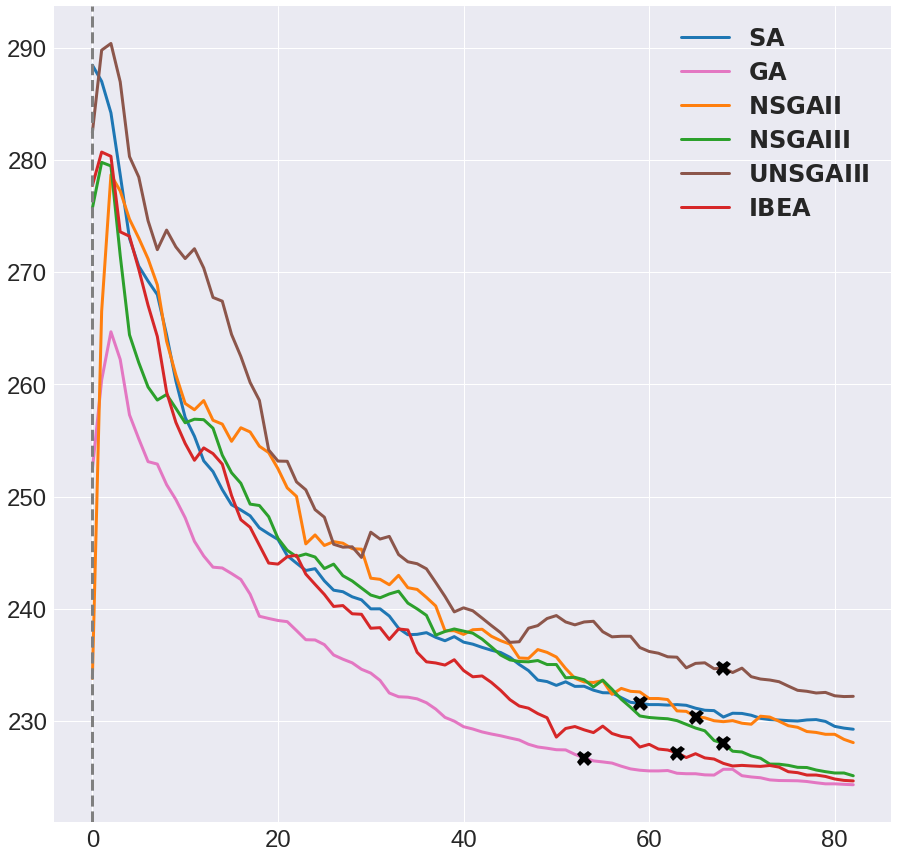

In [24]:
sa_curve = np.mean(plot_data_SA["fuel_consumption"],axis=0)
ga_curve = np.mean(plot_data_GA["fuel_consumption"],axis=0)
nsga2_curve = np.mean(plot_data_NSGAII["fuel_consumption"],axis=0)
nsga3_curve = np.mean(plot_data_NSGAIII["fuel_consumption"],axis=0)
unsga3_curve = np.mean(plot_data_UNSGAIII["fuel_consumption"],axis=0)
ibea_curve = np.mean(plot_data_IBEA["fuel_consumption"],axis=0)
curves = np.array([sa_curve,ga_curve,nsga2_curve,nsga3_curve,unsga3_curve,ibea_curve])
lables =["SA","GA","NSGAII","NSGAIII","UNSGAIII","IBEA"]




plot_conv_curves(curves,lables)

(<AxesSubplot:>, <Figure size 1080x1080 with 1 Axes>)

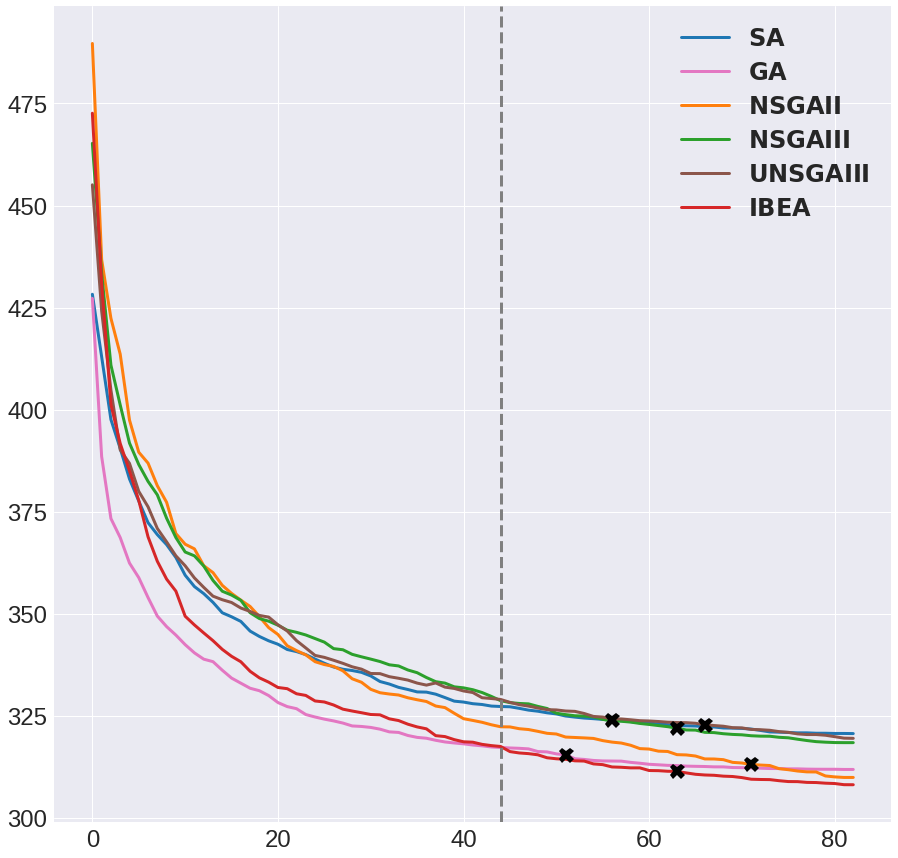

In [12]:
sa_curve = np.mean(plot_data_SA["distance_to_origin"],axis=0)
ga_curve = np.mean(plot_data_GA["distance_to_origin"],axis=0)
nsga2_curve = np.mean(plot_data_NSGAII["distance_to_origin"],axis=0)
nsga3_curve = np.mean(plot_data_NSGAIII["distance_to_origin"],axis=0)
unsga3_curve = np.mean(plot_data_UNSGAIII["distance_to_origin"],axis=0)
ibea_curve = np.mean(plot_data_IBEA["distance_to_origin"],axis=0)
curves = np.array([sa_curve,ga_curve,nsga2_curve,nsga3_curve,unsga3_curve,ibea_curve])
lables =["SA","GA","NSGAII","NSGAIII","UNSGAIII","IBEA"]




plot_conv_curves(curves,lables)

(<AxesSubplot:>, <Figure size 1080x1080 with 1 Axes>)

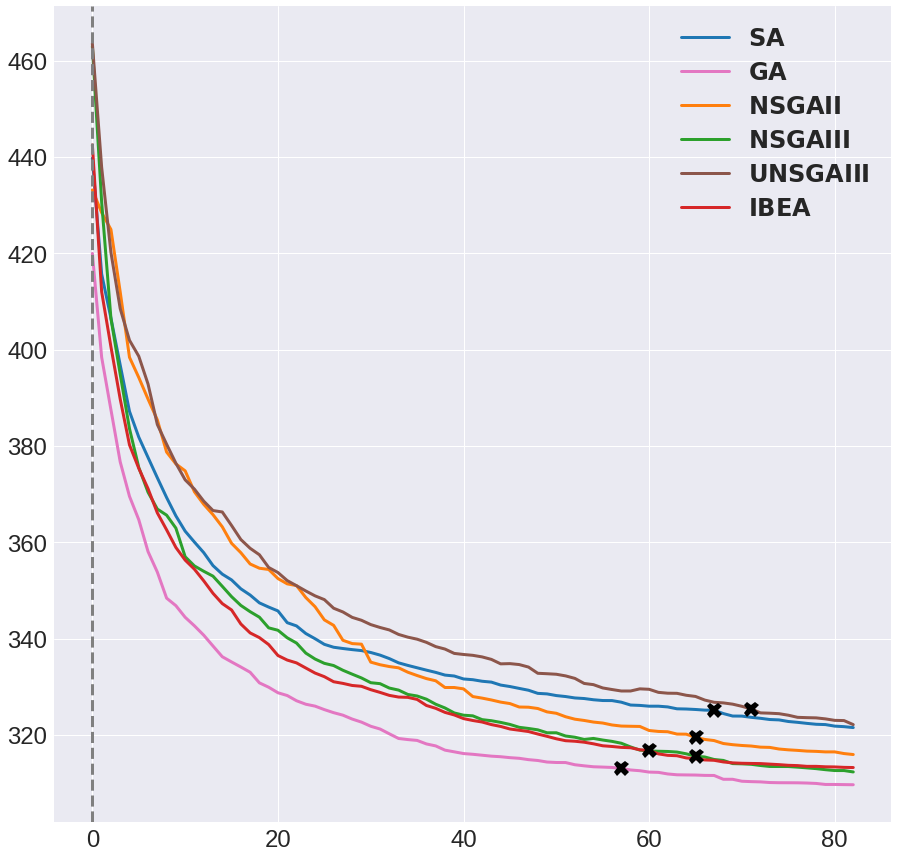

In [25]:
sa_curve = np.mean(plot_data_SA["distance_to_origin"],axis=0)
ga_curve = np.mean(plot_data_GA["distance_to_origin"],axis=0)
nsga2_curve = np.mean(plot_data_NSGAII["distance_to_origin"],axis=0)
nsga3_curve = np.mean(plot_data_NSGAIII["distance_to_origin"],axis=0)
unsga3_curve = np.mean(plot_data_UNSGAIII["distance_to_origin"],axis=0)
ibea_curve = np.mean(plot_data_IBEA["distance_to_origin"],axis=0)
curves = np.array([sa_curve,ga_curve,nsga2_curve,nsga3_curve,unsga3_curve,ibea_curve])
lables =["SA","GA","NSGAII","NSGAIII","UNSGAIII","IBEA"]




plot_conv_curves(curves,lables)

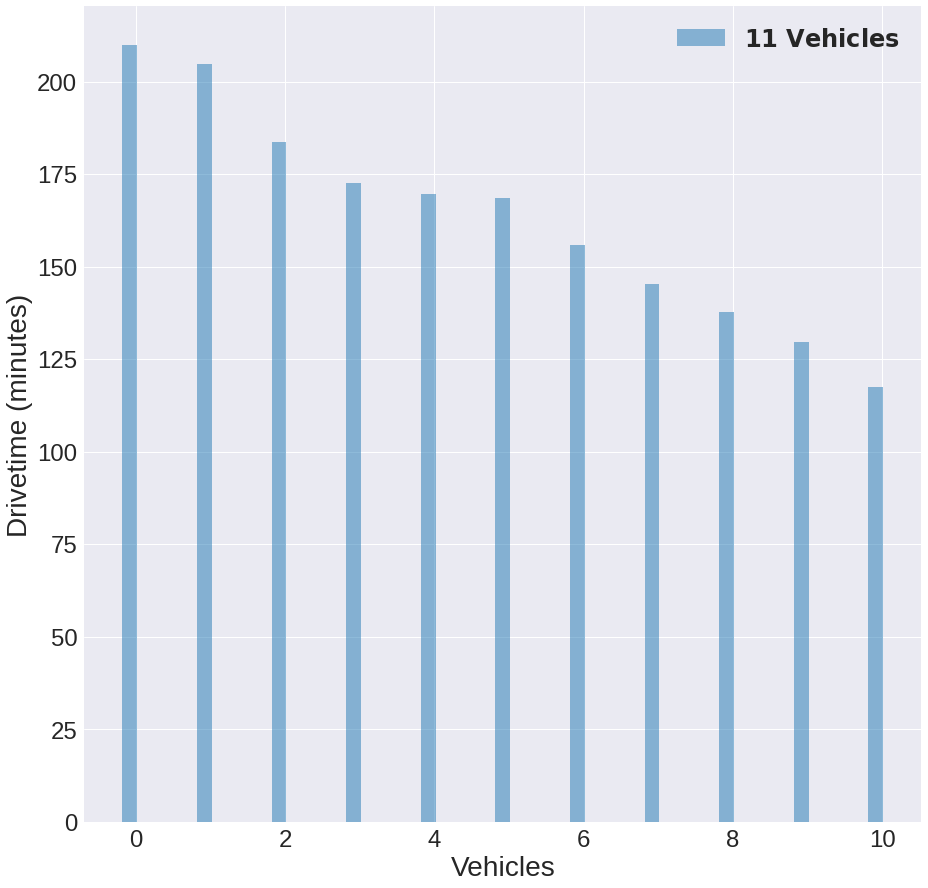

In [13]:
ga_df = pd.DataFrame(plot_data_GA)
ga_df["final_distance_to_origin"] =  [x[1]["distance_to_origin"][-1]for x in ga_df.iterrows()]
routes = ga_df.sort_values(by = "final_distance_to_origin").head(1).paths.to_list()[0]
ga_df["Parameter Group"] = 1
ga_best = ga_df.head(1)
plot_vehicle_drivetimes(ga_best,1)

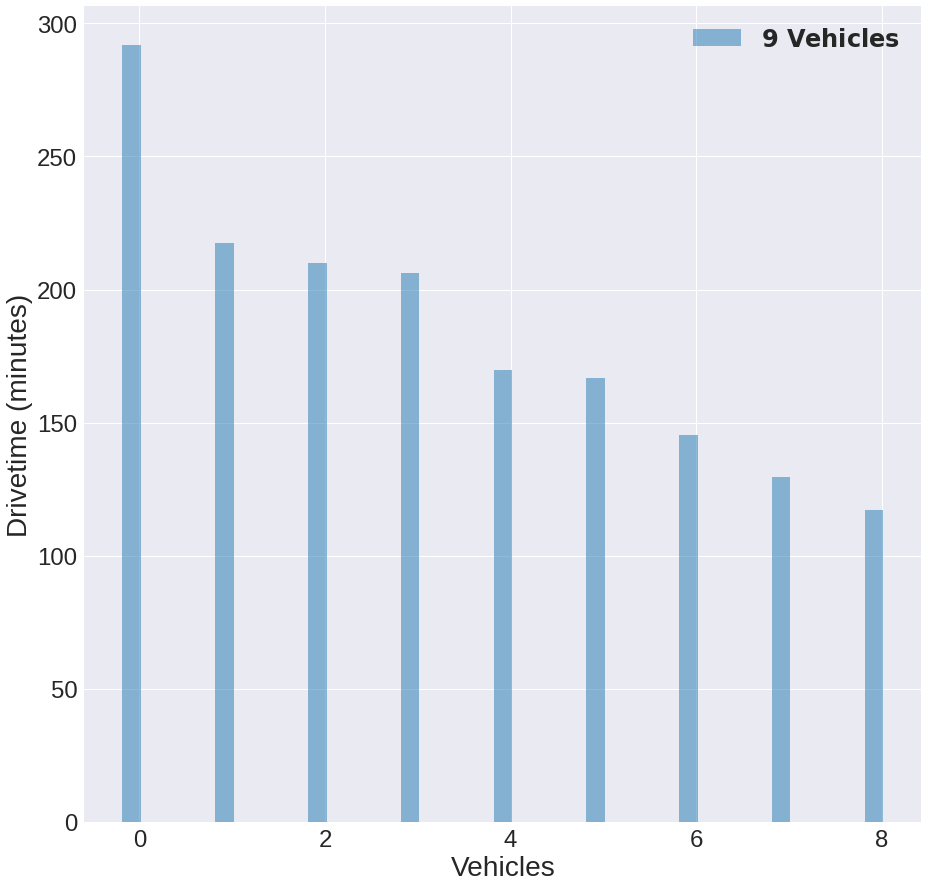

In [14]:
ibea_df = pd.DataFrame(plot_data_IBEA)
ibea_df["final_distance_to_origin"] =  [x[1]["distance_to_origin"][-1]for x in ibea_df.iterrows()]
routes = ibea_df.sort_values(by = "final_distance_to_origin").head(1).paths.to_list()[0]
ibea_df["Parameter Group"] = 1
ibea_best = ibea_df.head(1)
plot_vehicle_drivetimes(ibea_best,1)

In [11]:
numerical_path = get_numerical_path(best_sol.path,vehicles)
vehicle_routes = []
vehicle_stops = []
vehicle_stop_demands = []
for v_route in numerical_path:
    vehicle_stop_demands.append(np.array(customer_demands)[v_route[1:]])
    vehicle_stops.append(points_coordinate[v_route[1:]])
    vehicle_routes.append(decode_routes(generate_routes(points_coordinate[v_route],api)))

100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


In [13]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine
from folium.plugins import HeatMap, MarkerCluster
folium_map = folium.Map(location=np.mean(points_coordinate,axis=0), tiles='openstreetmap', zoom_start=7,min_zoom=6)
colors = ["red", "blue", "green", "purple", "orange", "darkred", "cyan", "black"]
type_colors=["black","red","green"]
numerical_route = numerical_path#get_numerical_path(best_sol.path,vehicles)
for routeNumber,route in enumerate(numerical_route):

    routes = []
    
    for stop in route:
        nodeType = 0
        if stop in startNodeIndeces:
            nodeType=2
        elif stop in endNodeIndeces:
            nodeType=1
        coordinates = (points_coordinate[stop][0],points_coordinate[stop][1])
        routes.append(coordinates)
        Marker(coordinates,icon=folium.Icon(color=type_colors[nodeType],icon_color='#FFFF00'),popup=customer_demands[stop]).add_to(folium_map)
      
    
    PolyLine(vehicle_routes[routeNumber],color=colors[routeNumber%len(colors)]).add_to(folium_map)
    
        

folium_map


[['V0', 42, 33, 30, 19, 34, 16, 2],
 ['V6', 31, 37, 26, 2],
 ['V3', 48, 4],
 ['V4', 11, 18, 39, 20],
 ['V7', 47, 46, 24, 27, 2],
 ['V2', 50, 44, 7, 8, 2],
 ['V9', 36, 17, 25, 13, 14, 29, 38, 2],
 ['V10', 41, 45],
 ['V12', 49, 3, 12, 23, 9, 28, 20],
 ['V13', 22, 43, 20]]